In [1]:
from pyemd import *
import numpy as np
import torch
from torch import optim
from torch.autograd import Variable
import pdb
import torch.nn.functional as F
from matplotlib import pyplot
import random

np.set_printoptions(precision=3)

### Cramer metric for discrete pmfs

$C(P,Q) = \sum_{i = 1}^{n_a} F_p(x_i) - F_q(x_i)$, i.e it's simply the difference in CDF's between the two histograms

In [2]:
NUM_ATOMS = 51

# we need a num_atoms x num_atoms mask to calculate the CDFs at every point
mask = np.zeros((NUM_ATOMS, NUM_ATOMS))
for i in range(NUM_ATOMS + 1):
    for j in range(i):
        mask[i-1, j] = 1
        
mask = Variable(torch.from_numpy(mask).float())
print mask
        

Variable containing:
    1     0     0  ...      0     0     0
    1     1     0  ...      0     0     0
    1     1     1  ...      0     0     0
       ...          ⋱          ...       
    1     1     1  ...      1     0     0
    1     1     1  ...      1     1     0
    1     1     1  ...      1     1     1
[torch.FloatTensor of size 51x51]

Variable containing:
    1     0     0  ...      0     0     0
    1     1     0  ...      0     0     0
    1     1     1  ...      0     0     0
       ...          ⋱          ...       
    1     1     1  ...      1     0     0
    1     1     1  ...      1     1     0
    1     1     1  ...      1     1     1
[torch.FloatTensor of size 51x51]



In [3]:
# helper to get the CDF at every atom given a categorical distribution
def get_cdf(categorical_dist):
    '''
    categorical dist : (num_atoms, ) shape
    '''
    dist = categorical_dist.unsqueeze(0).expand(NUM_ATOMS, -1)
    cdf = (dist * mask).sum(dim=-1)
    return cdf

# just to make sure I understand how the package works
def Cramer_Loss(source_distribution, target_distribution):
    source_cdf = get_cdf(source_distribution)
    target_cdf = get_cdf(target_distribution)
    delta = source_cdf - target_cdf
    return (delta ** 2).sum() ** (.5)



### Experiments

In [4]:
def plot_dists(pmf_a, pmf_b, epoch, save=False):
    pyplot.bar(np.arange(NUM_ATOMS), pmf_a)
    pyplot.title('distributions at iteration {} (minimizing CRAMER dist)'.format(epoch))
    pyplot.bar(np.arange(NUM_ATOMS), pmf_b, width=0.4)
    if save: 
        pyplot.savefig('emd/{}.png'.format(epoch))
    pyplot.show()


In [5]:
def create_random_dist(MASS=50):
    # next, we build 2 different histograms, with the same amount of mass
    pmf = np.sort(np.random.uniform(high=MASS, size=[NUM_ATOMS - 1]))

    for i in range(NUM_ATOMS - 1):
        for j in range(i+1, NUM_ATOMS - 1):
            pmf[j] -= pmf[i]

    pmf = np.concatenate((pmf, [MASS - pmf.sum()])) / MASS
    
    return pmf

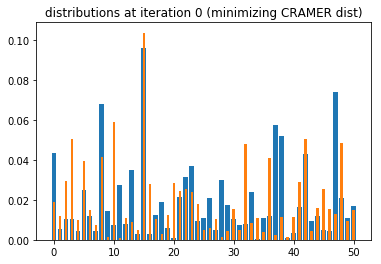

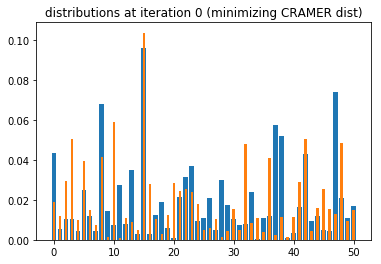

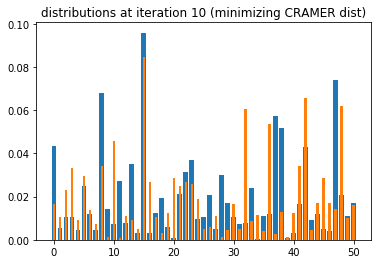

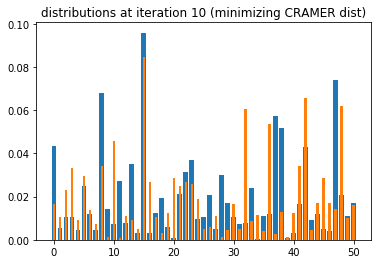

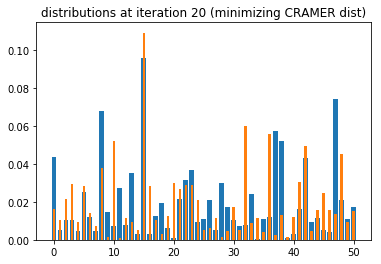

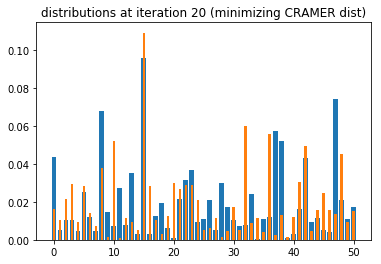

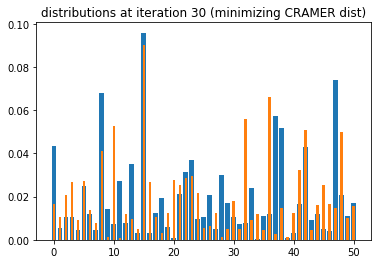

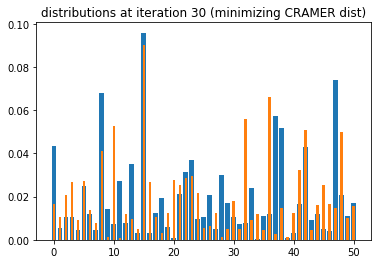

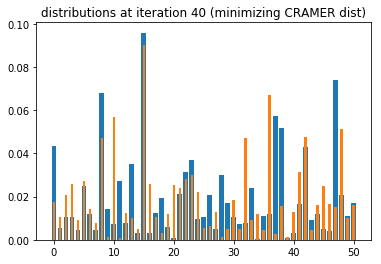

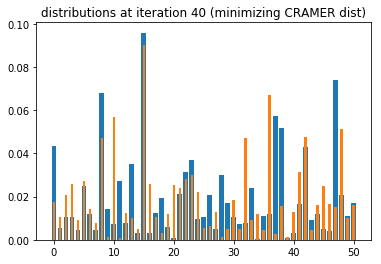

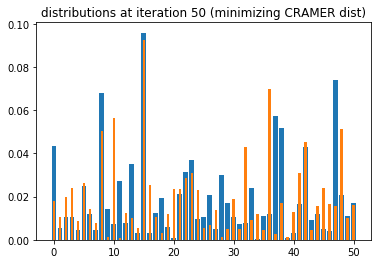

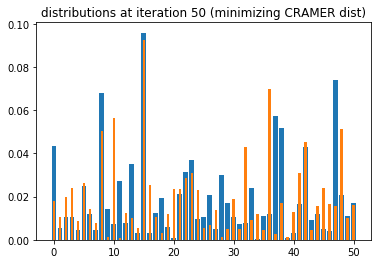

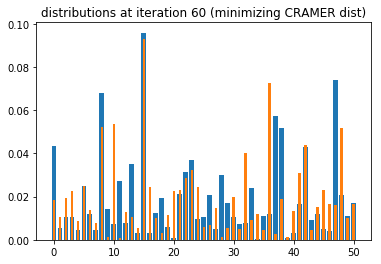

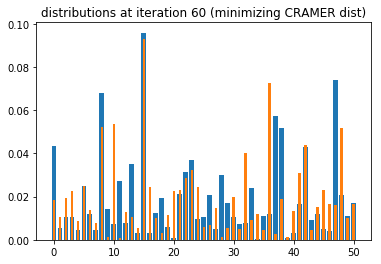

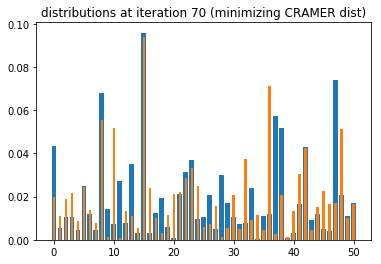

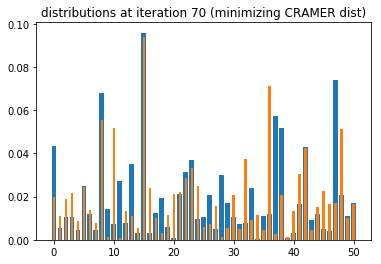

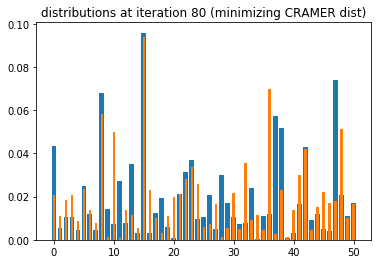

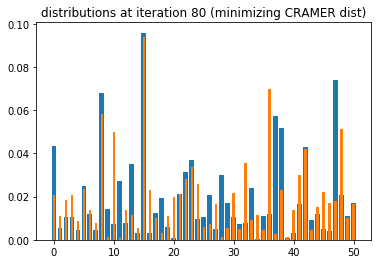

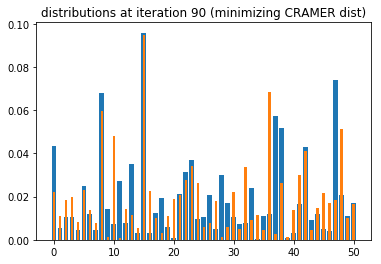

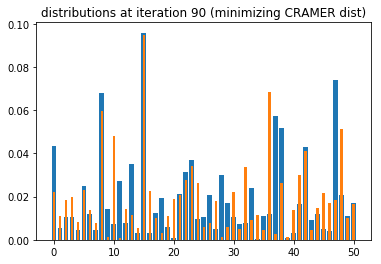

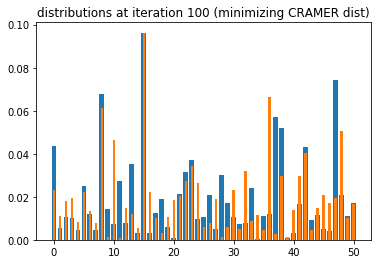

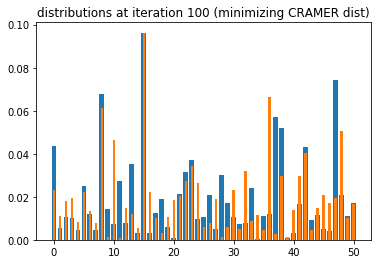

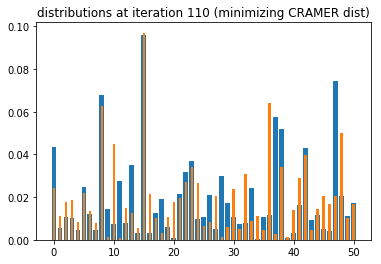

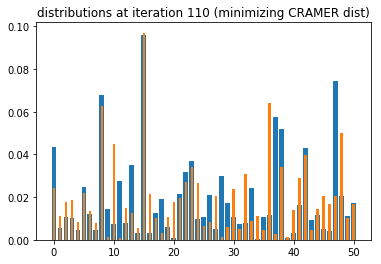

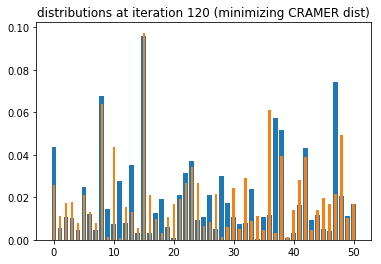

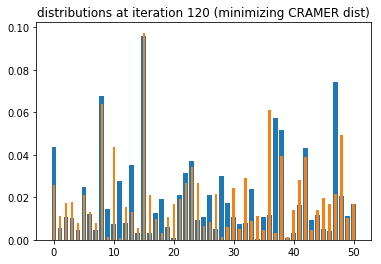

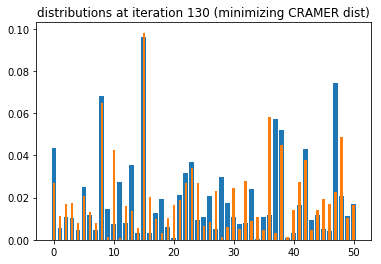

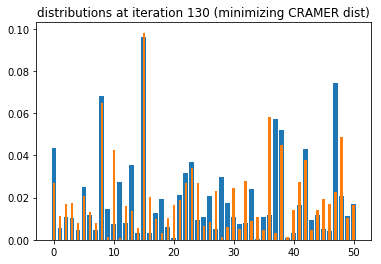

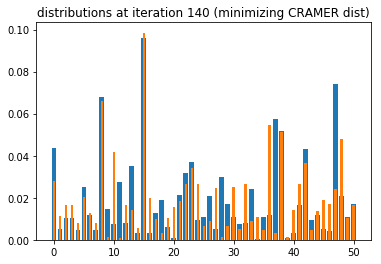

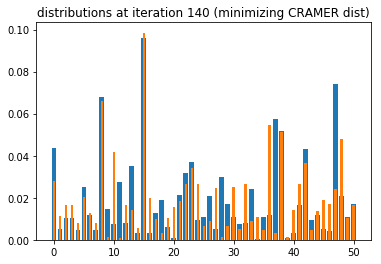

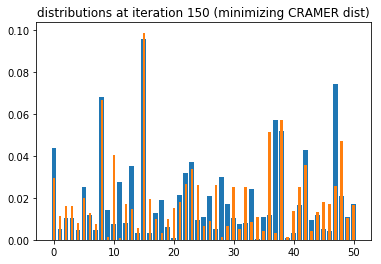

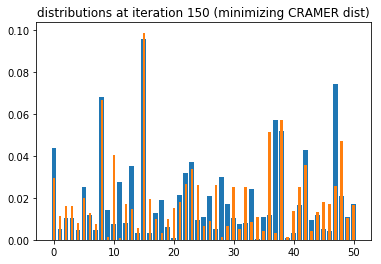

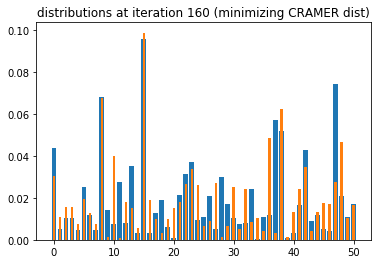

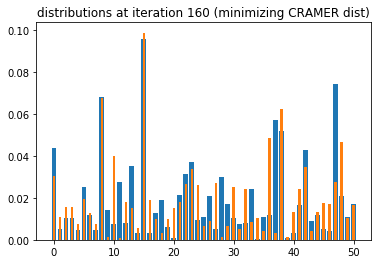

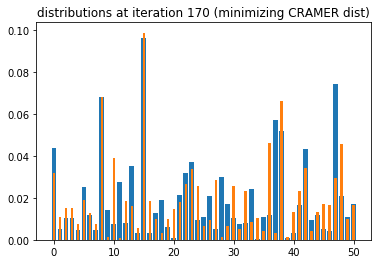

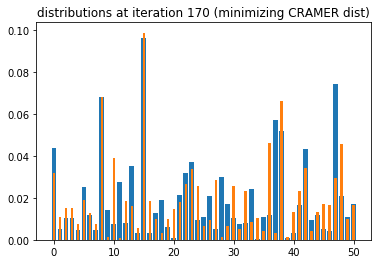

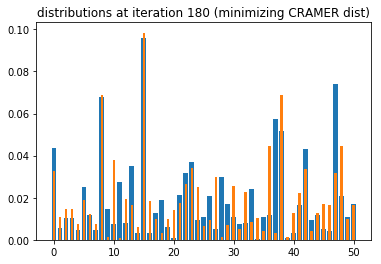

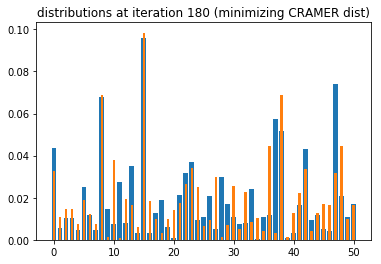

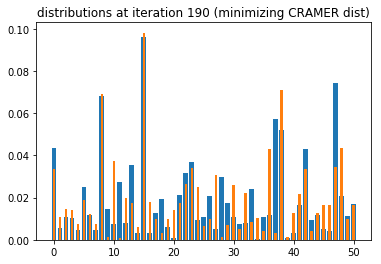

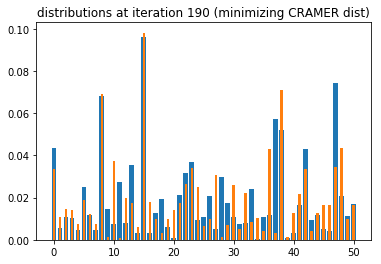

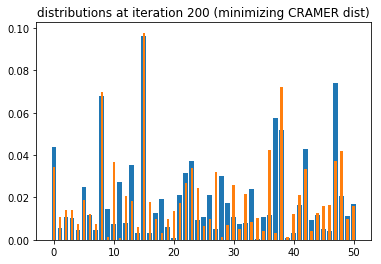

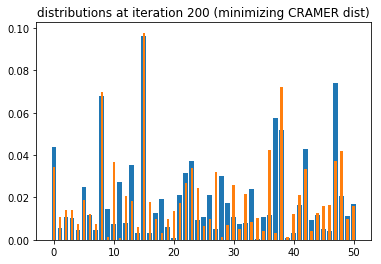

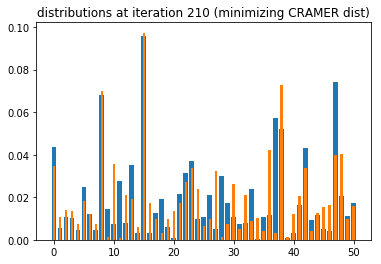

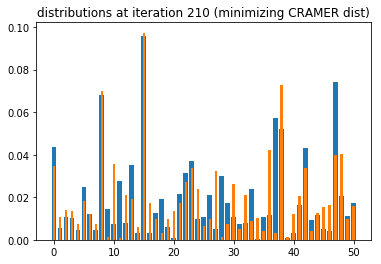

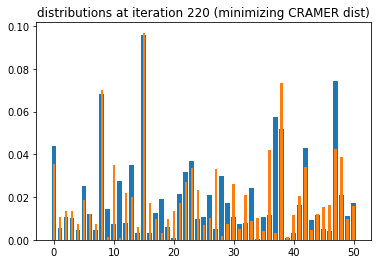

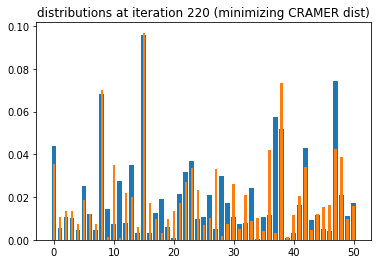

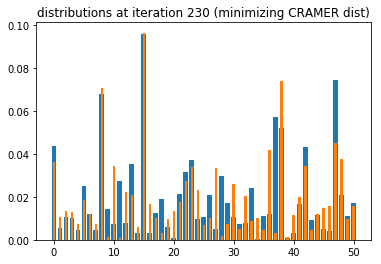

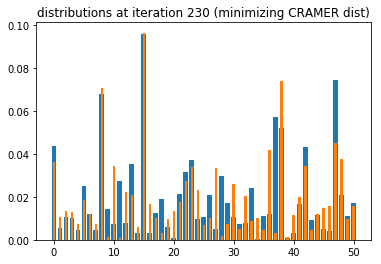

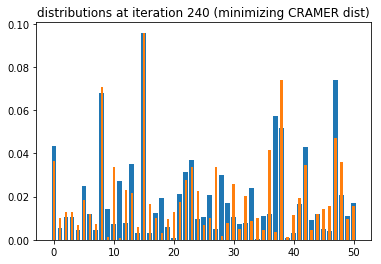

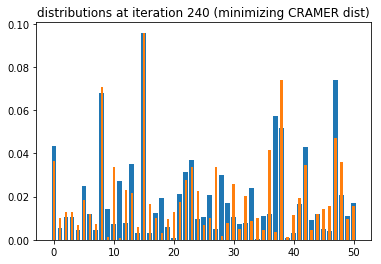

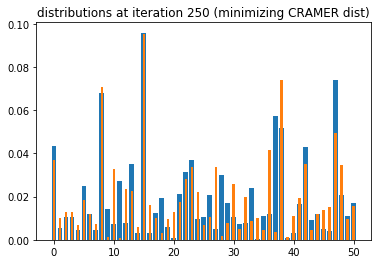

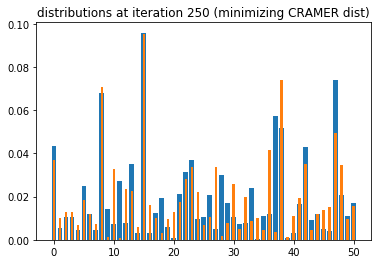

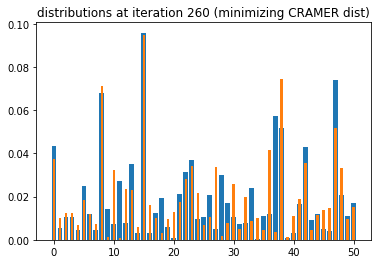

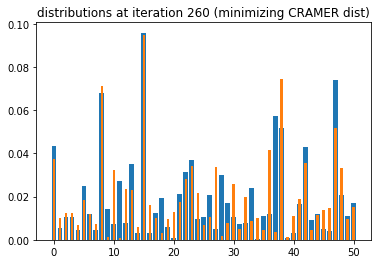

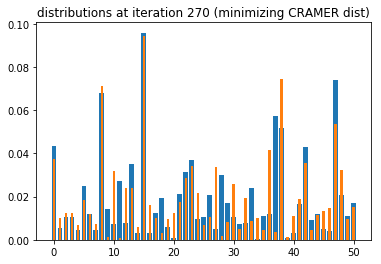

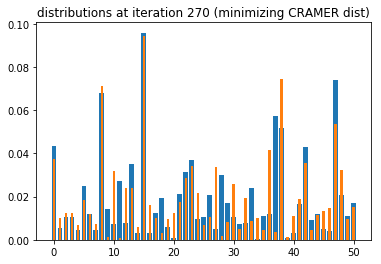

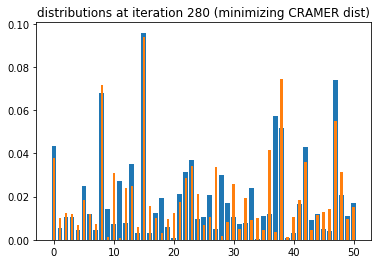

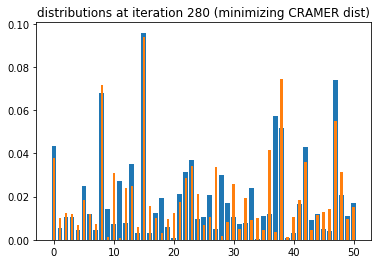

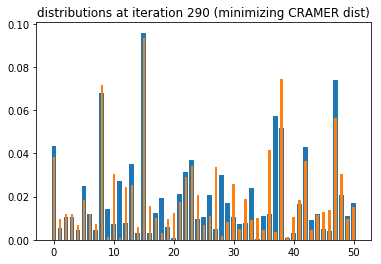

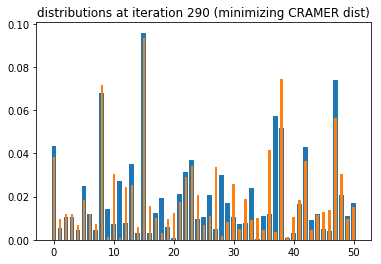

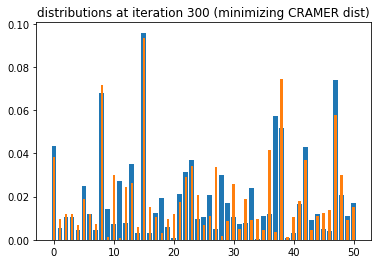

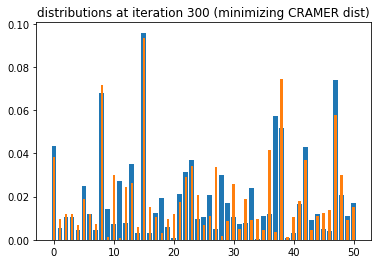

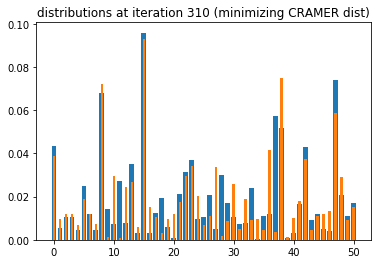

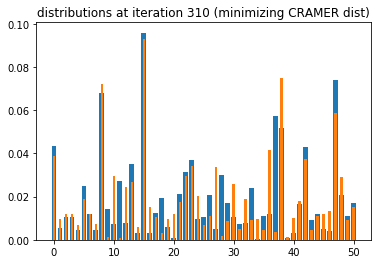

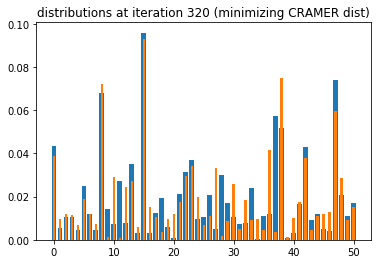

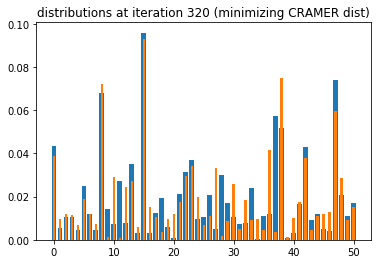

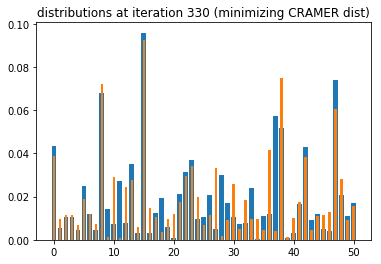

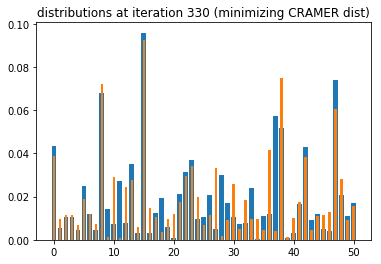

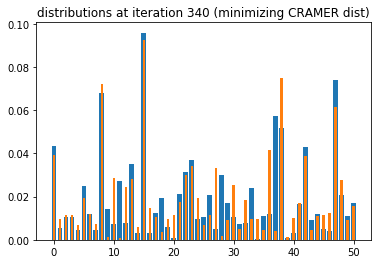

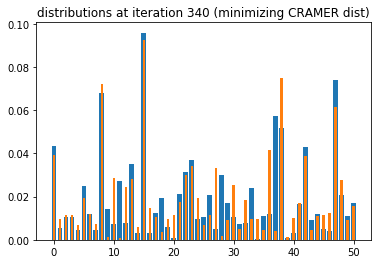

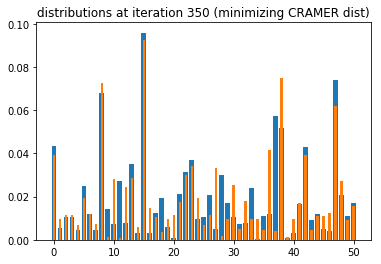

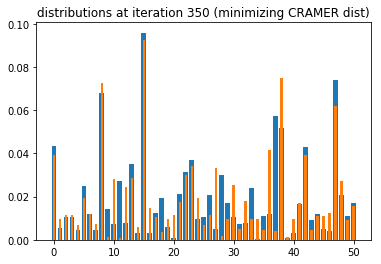

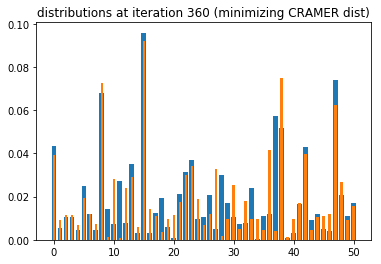

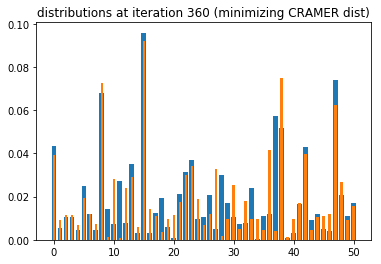

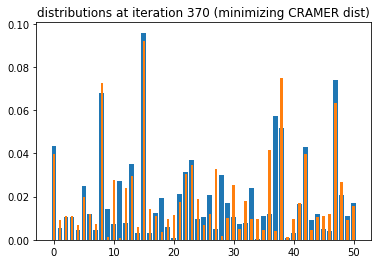

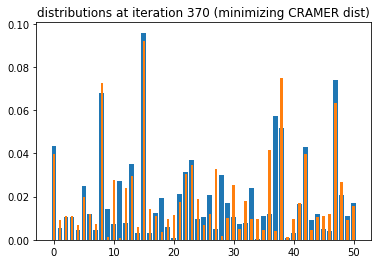

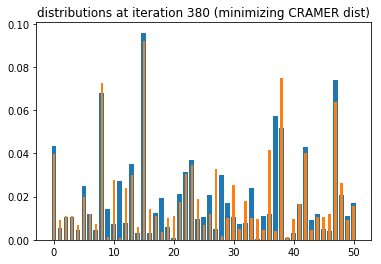

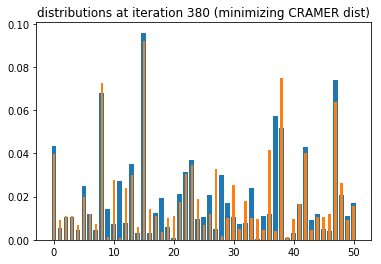

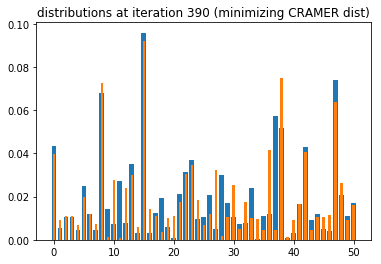

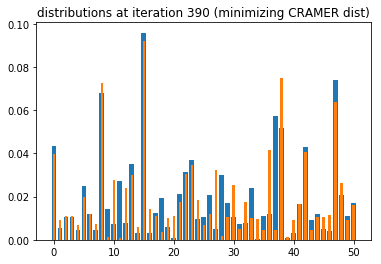

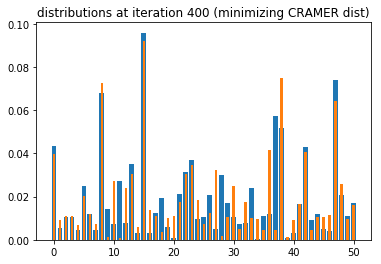

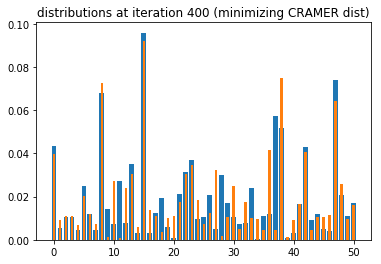

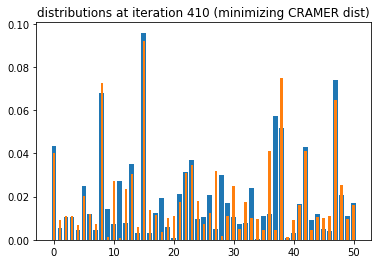

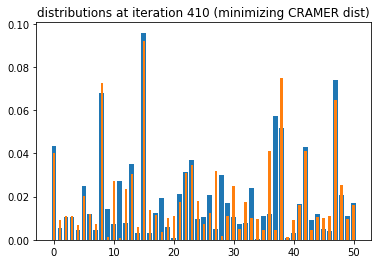

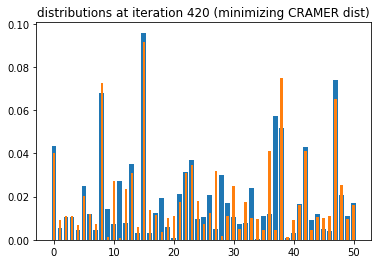

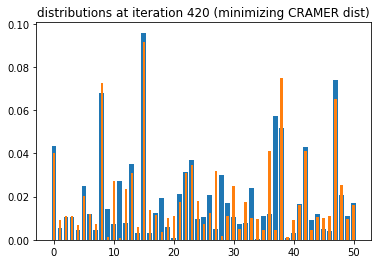

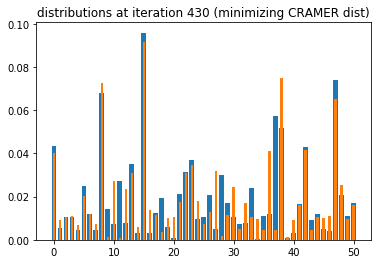

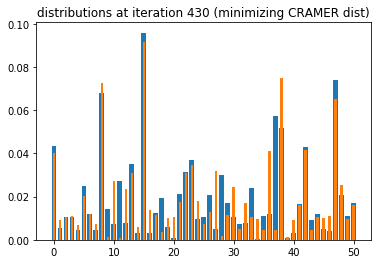

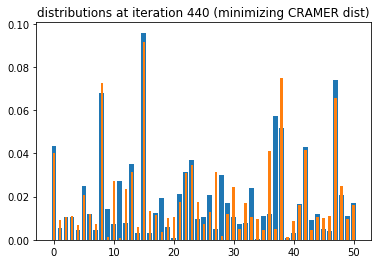

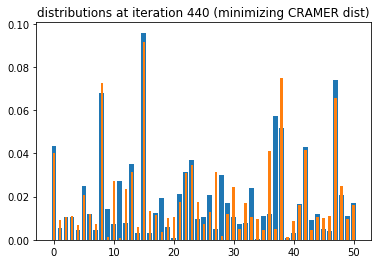

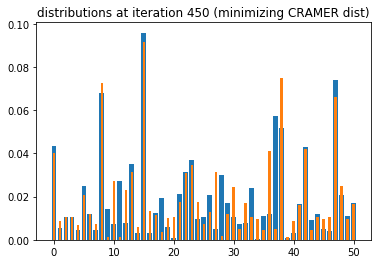

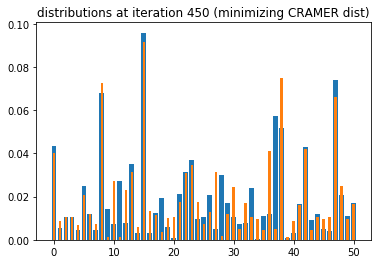

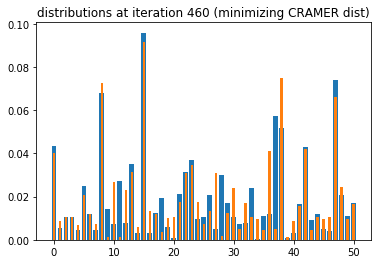

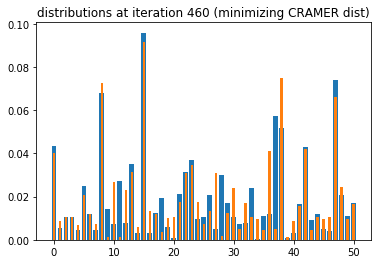

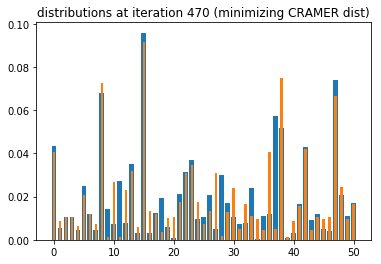

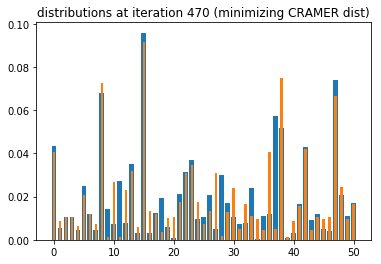

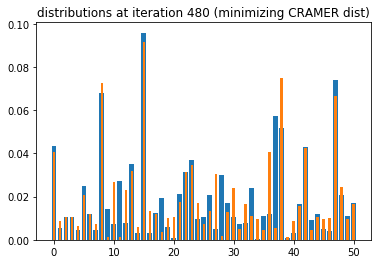

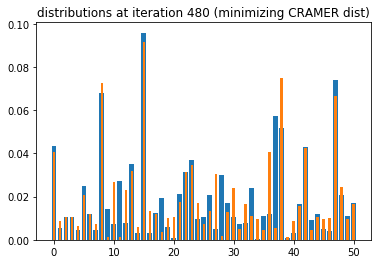

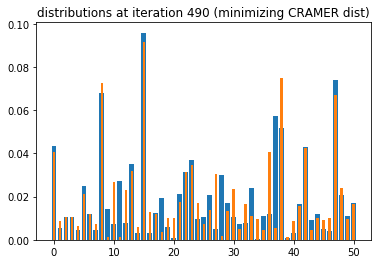

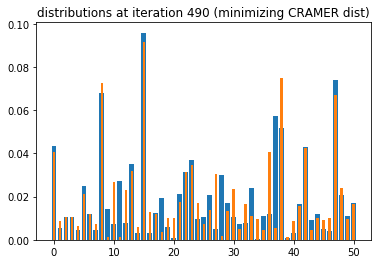

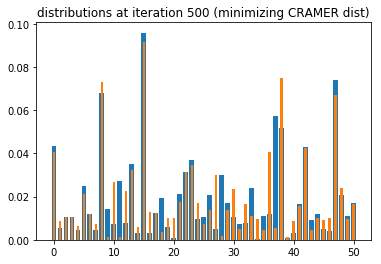

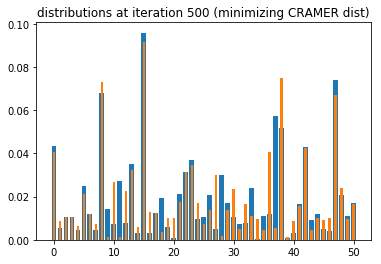

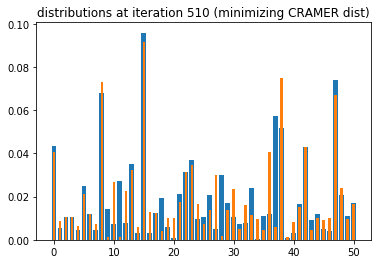

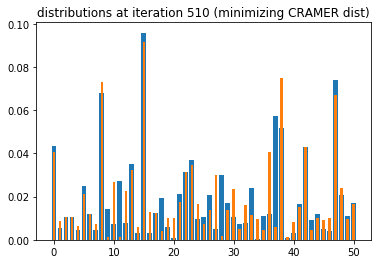

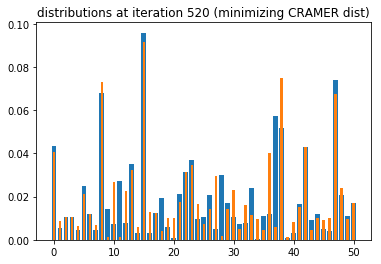

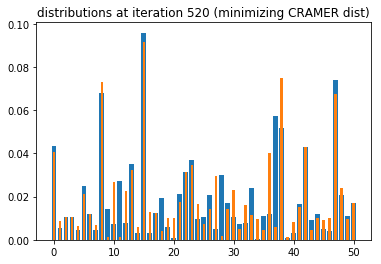

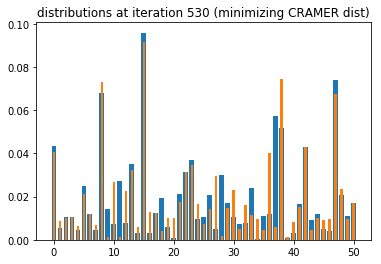

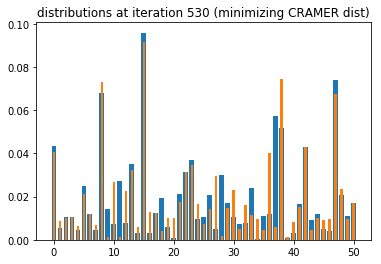

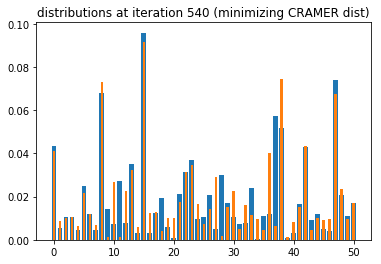

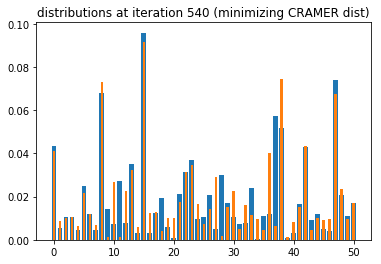

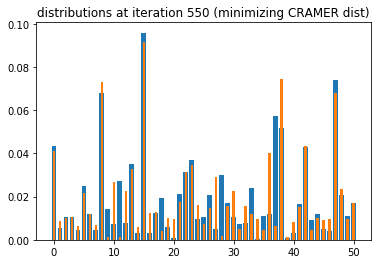

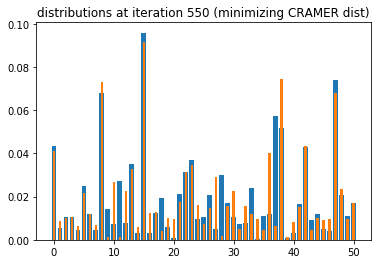

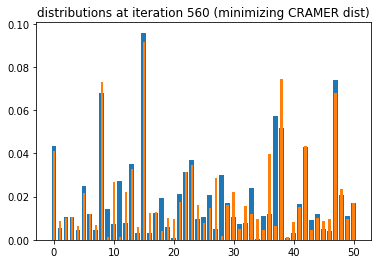

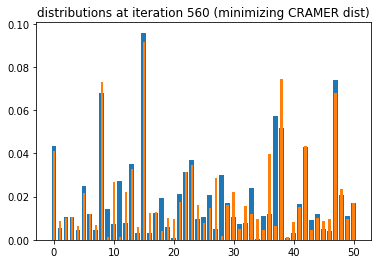

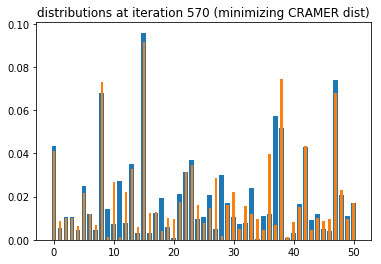

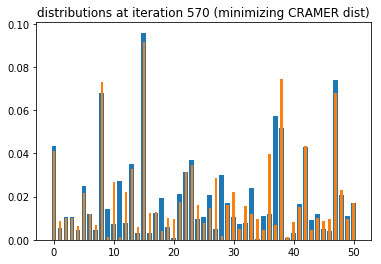

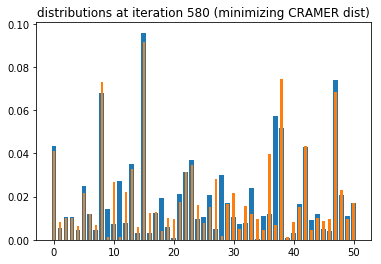

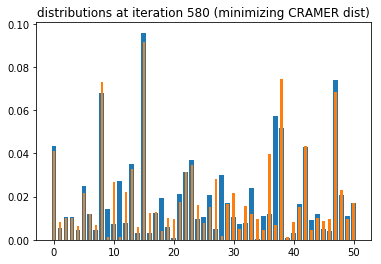

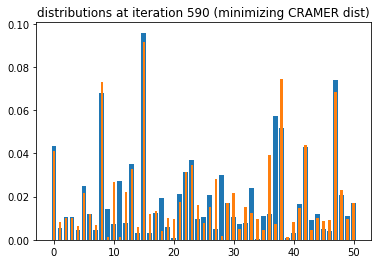

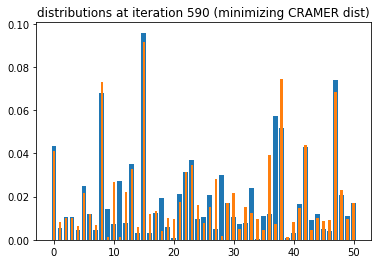

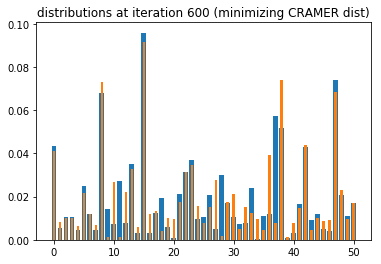

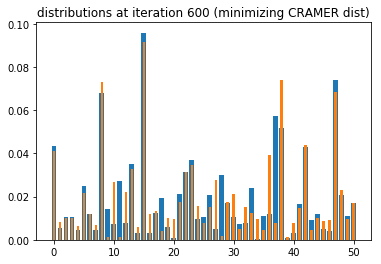

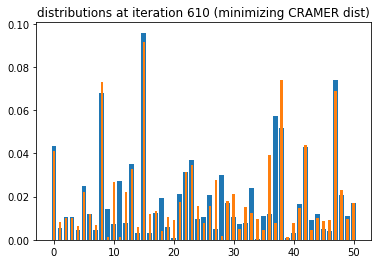

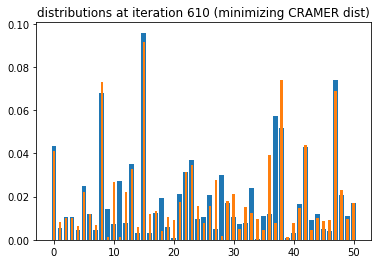

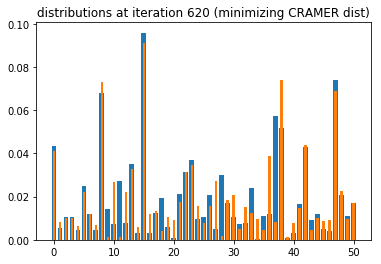

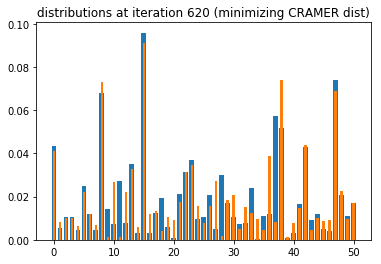

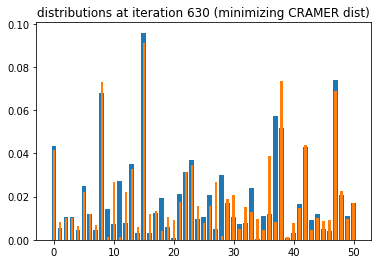

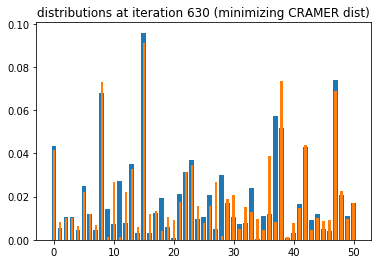

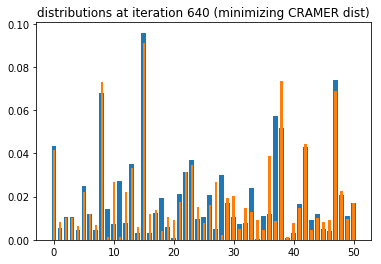

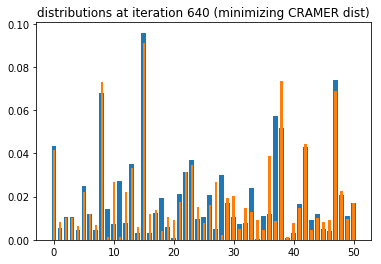

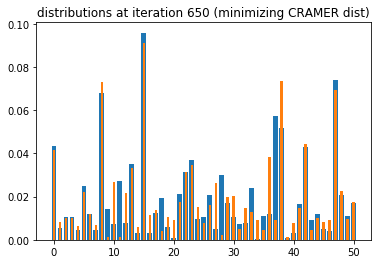

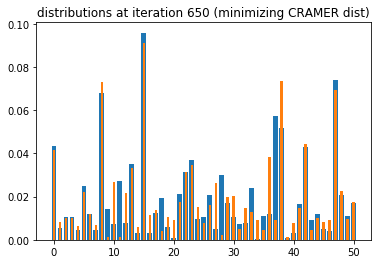

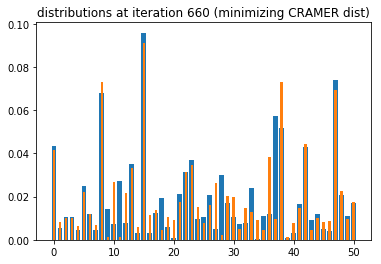

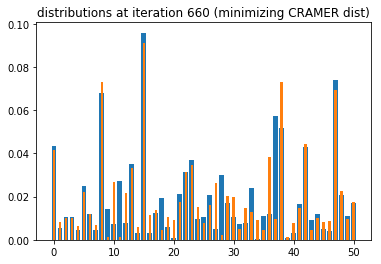

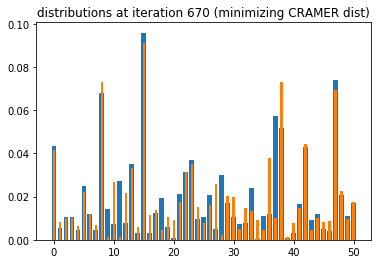

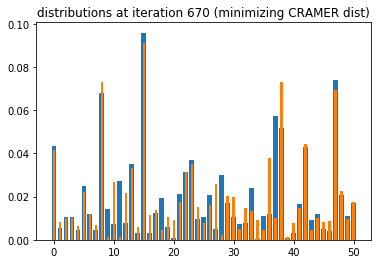

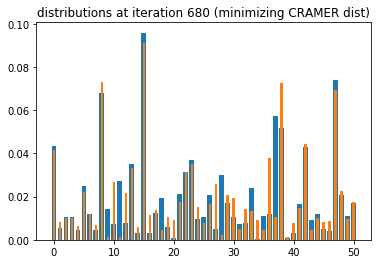

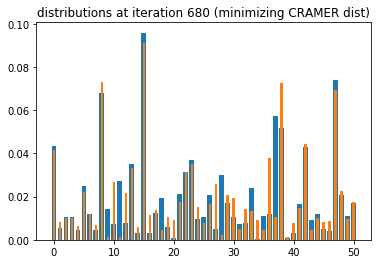

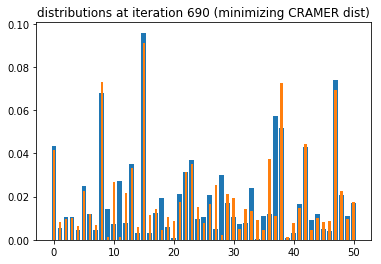

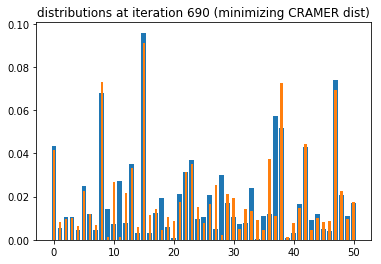

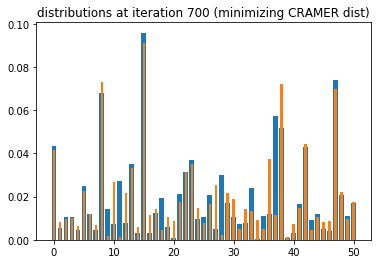

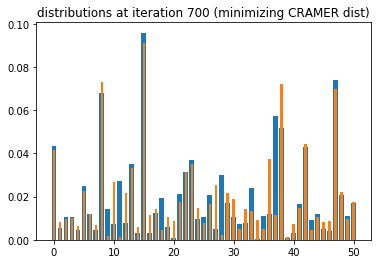

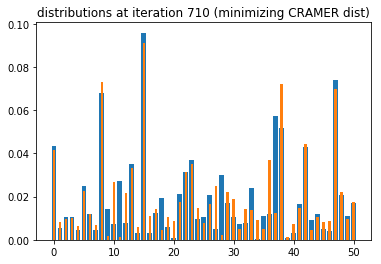

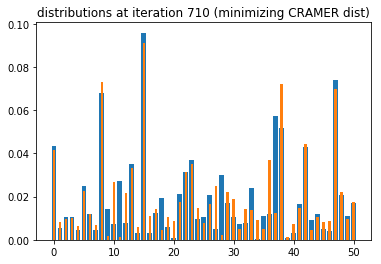

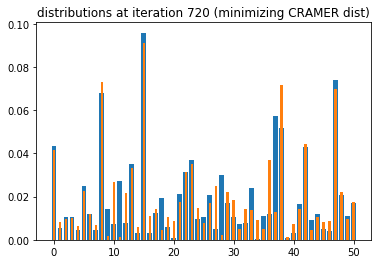

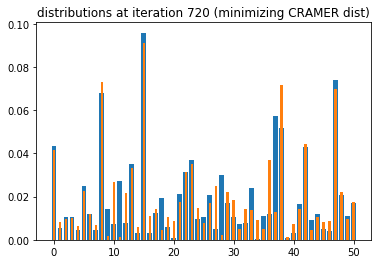

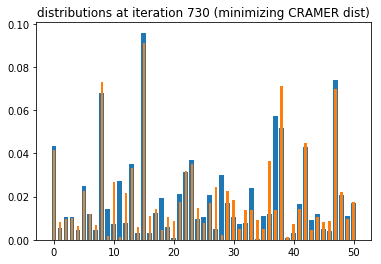

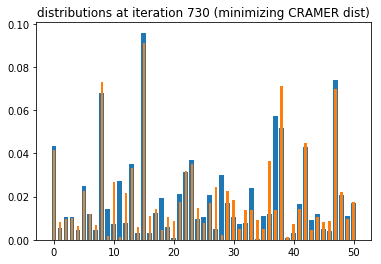

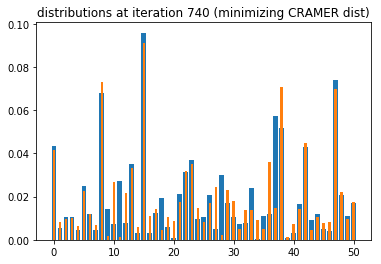

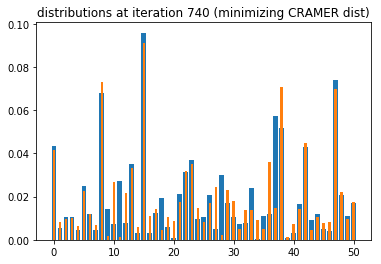

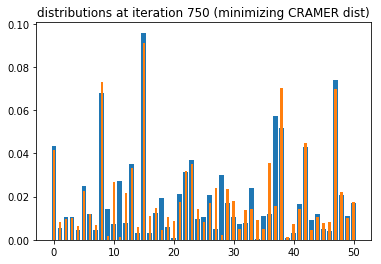

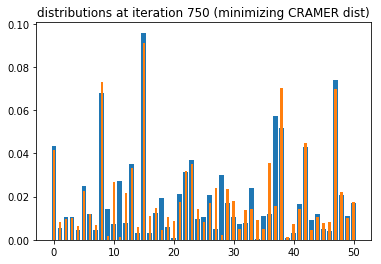

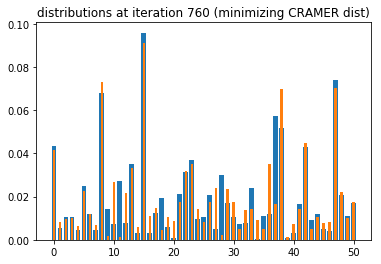

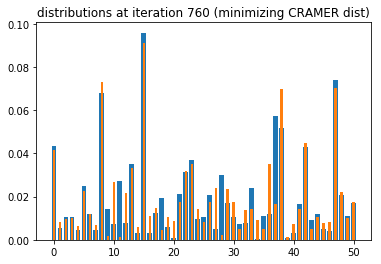

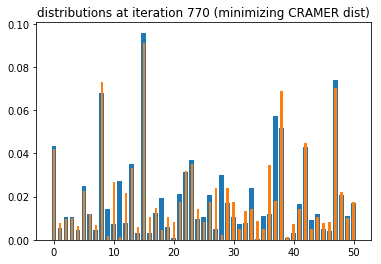

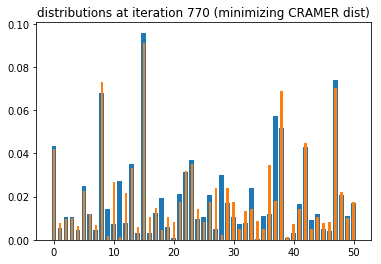

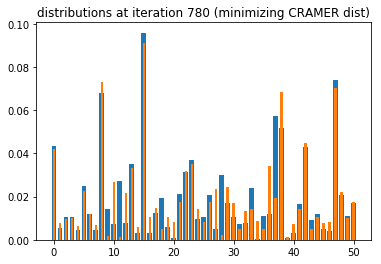

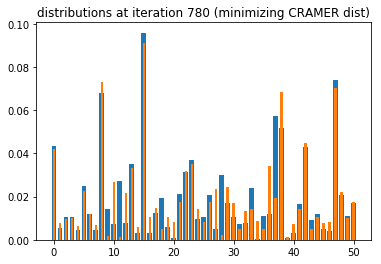

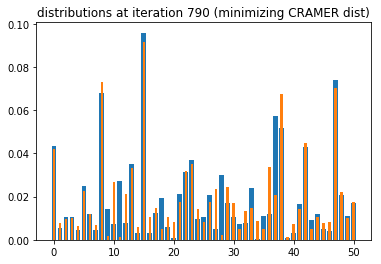

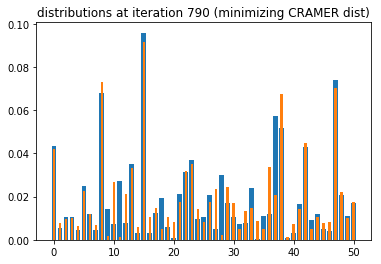

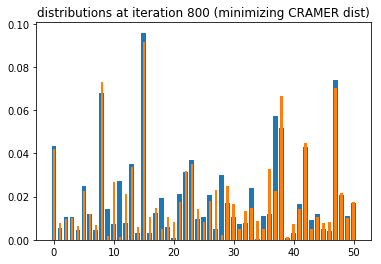

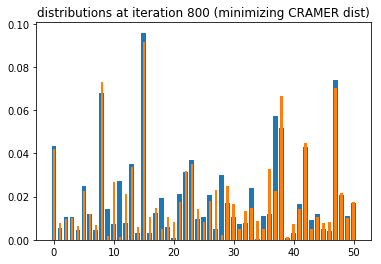

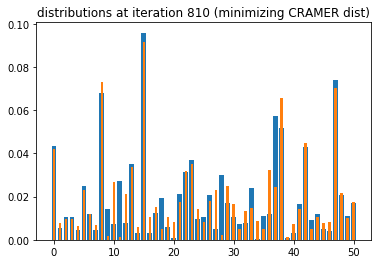

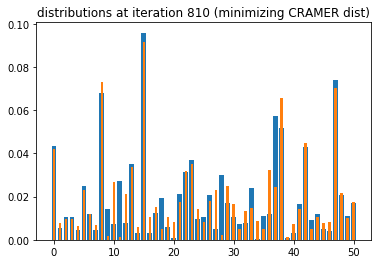

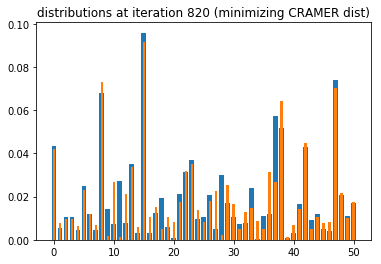

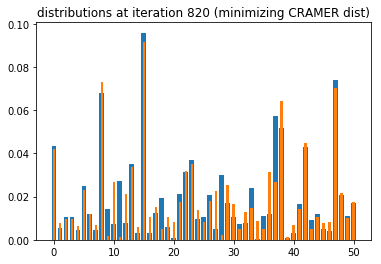

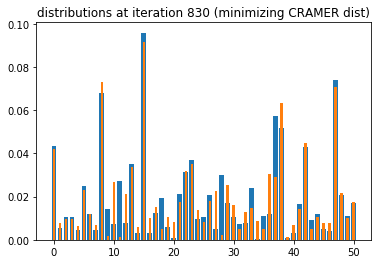

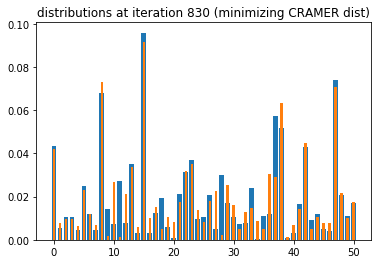

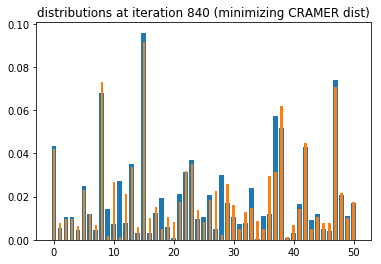

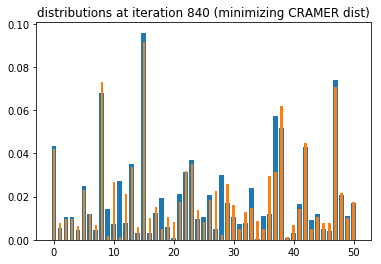

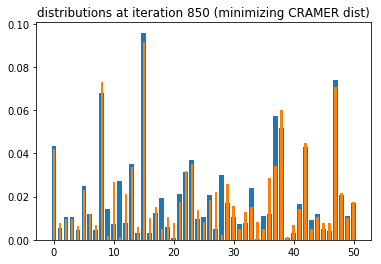

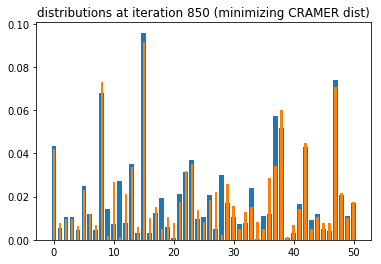

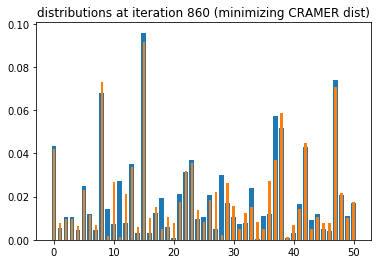

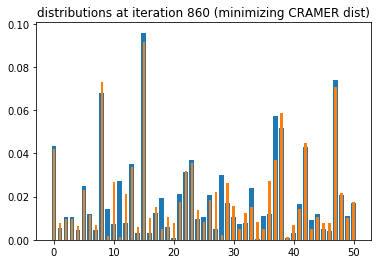

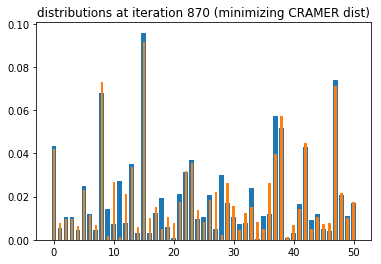

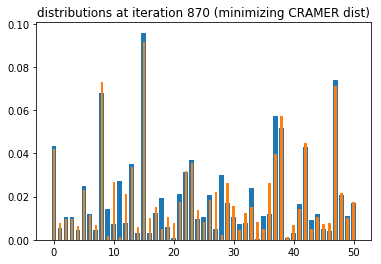

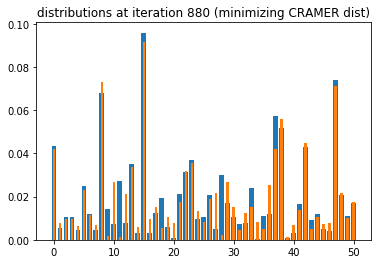

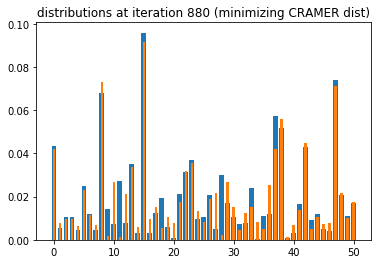

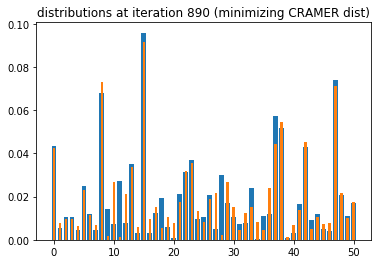

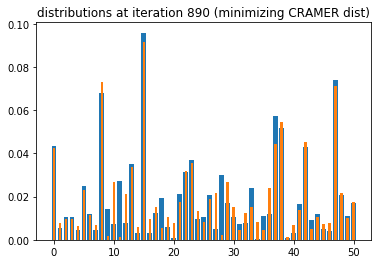

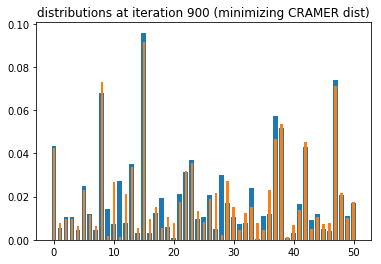

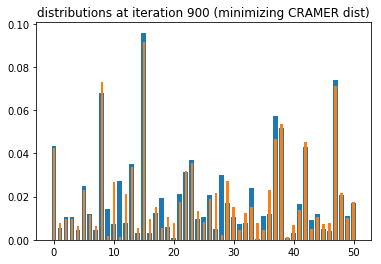

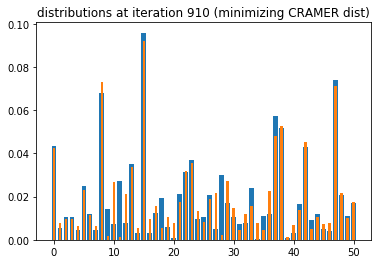

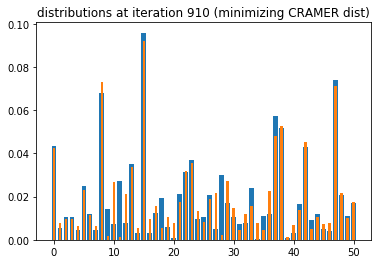

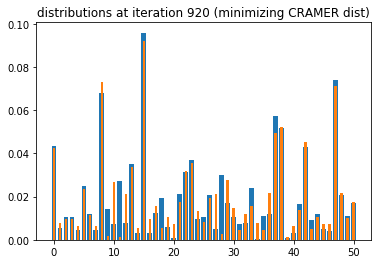

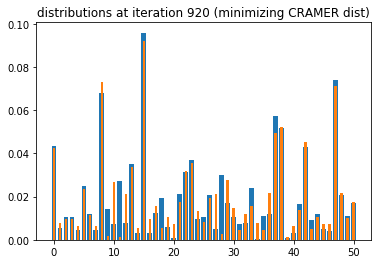

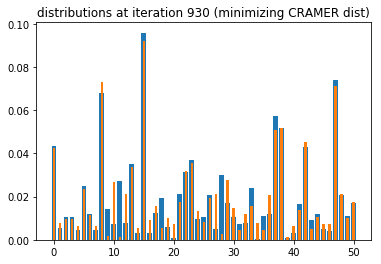

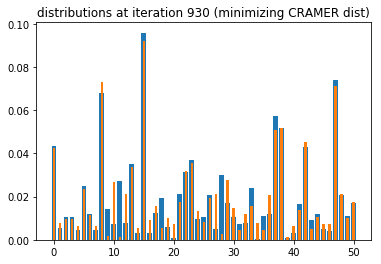

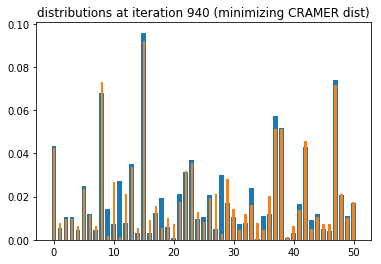

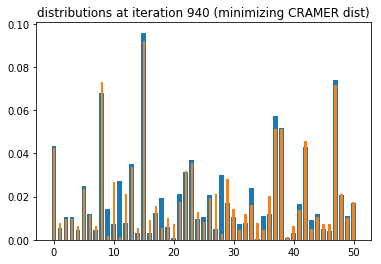

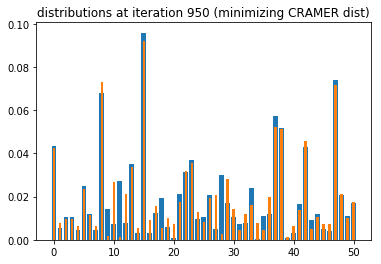

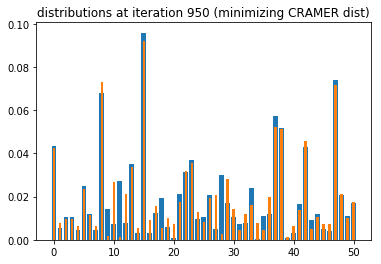

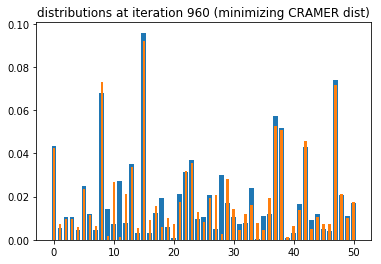

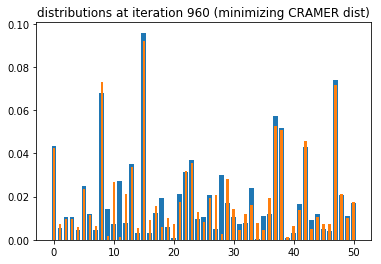

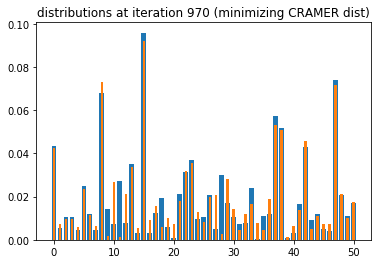

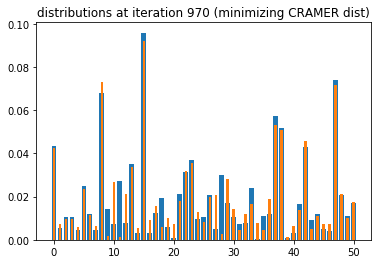

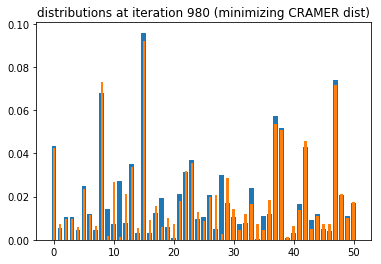

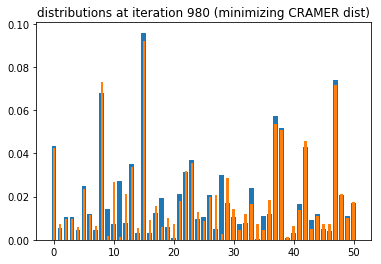

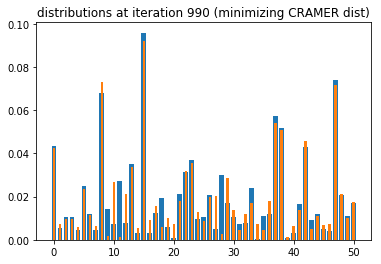

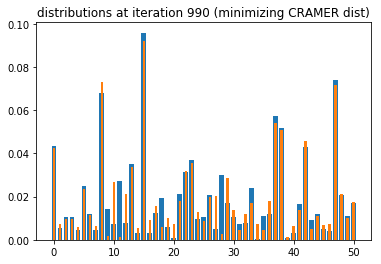

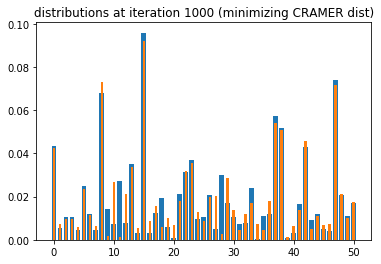

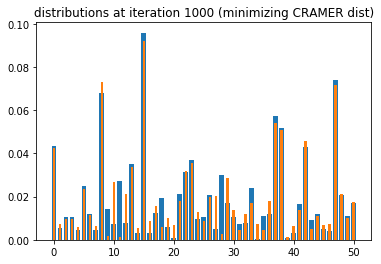

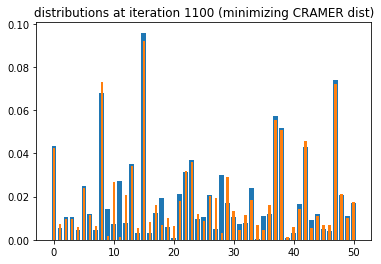

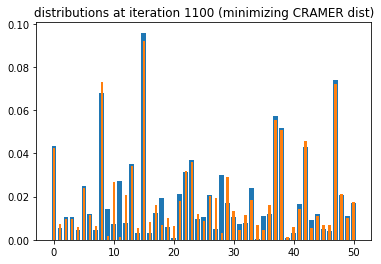

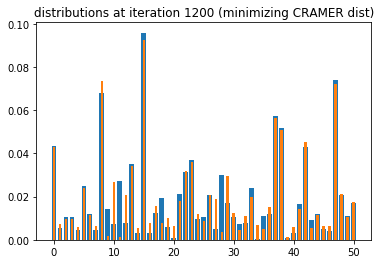

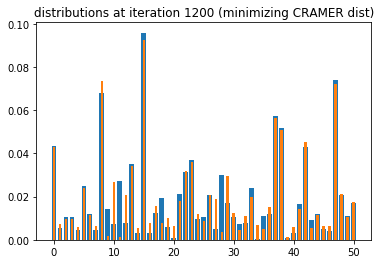

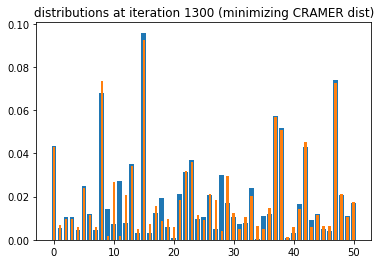

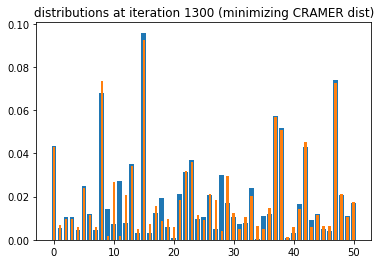

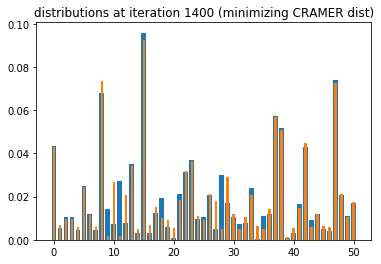

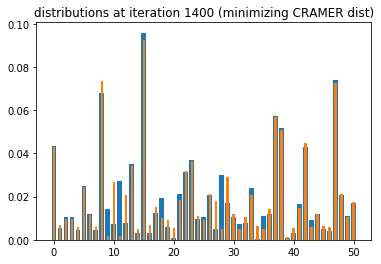

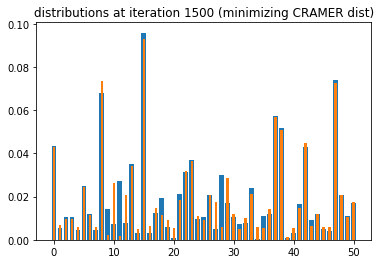

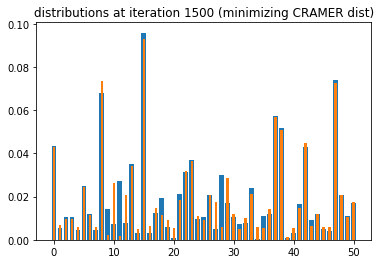

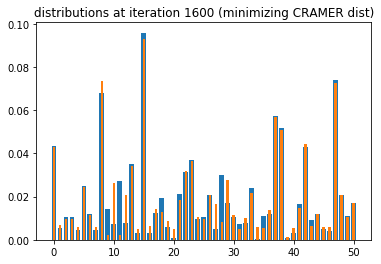

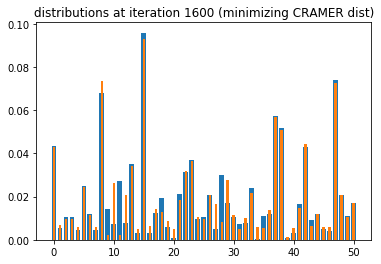

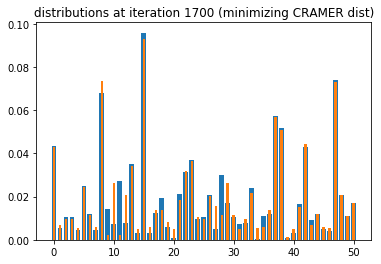

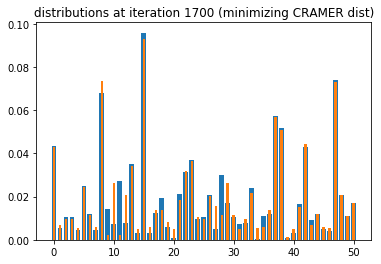

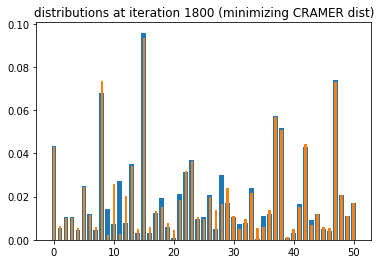

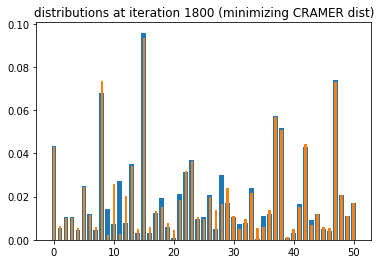

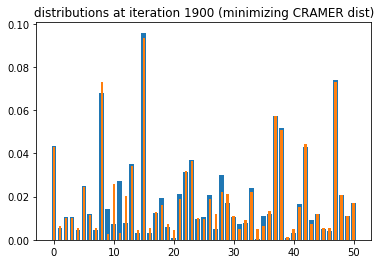

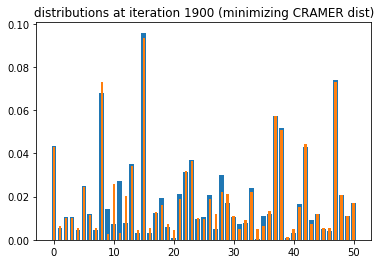

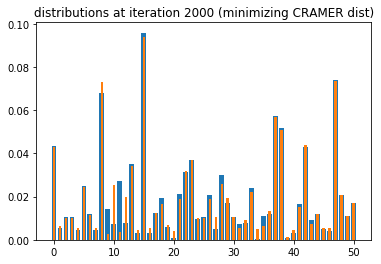

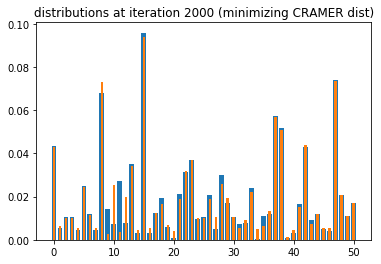

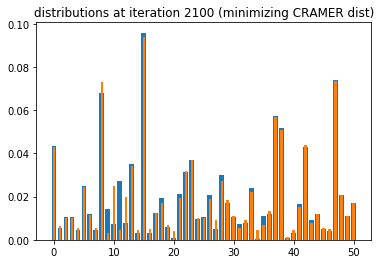

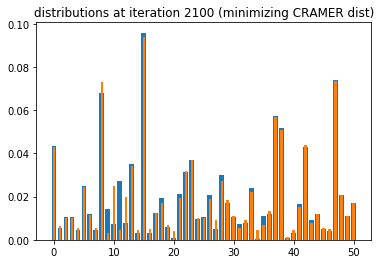

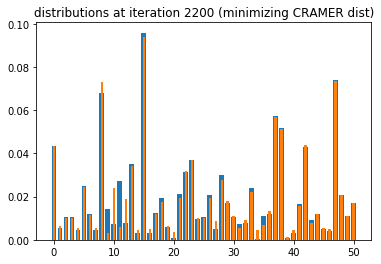

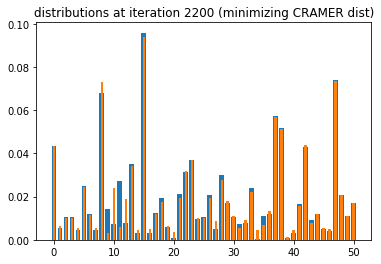

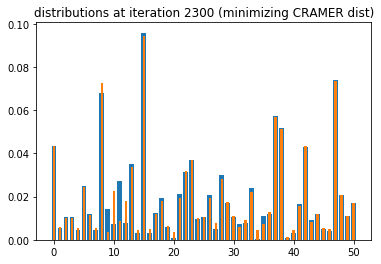

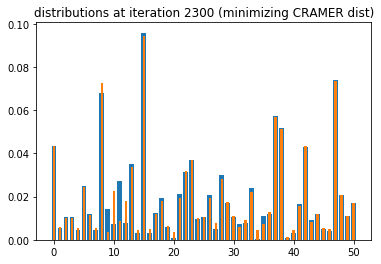

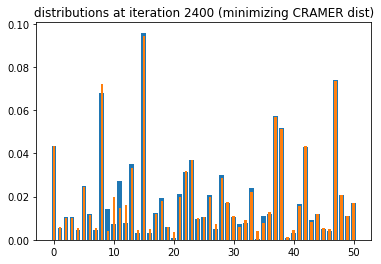

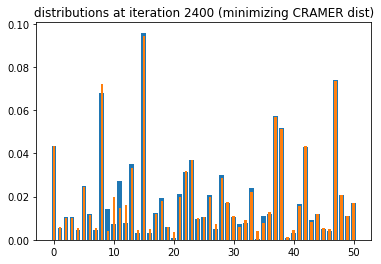

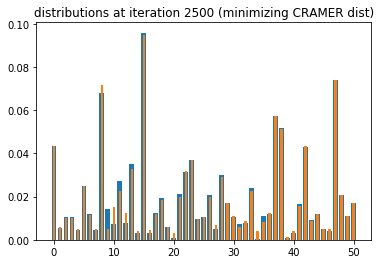

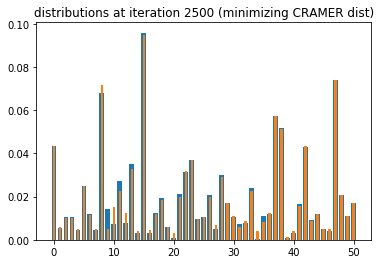

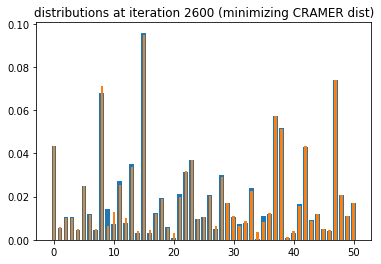

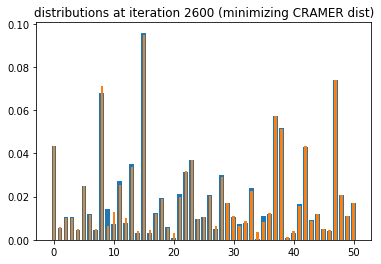

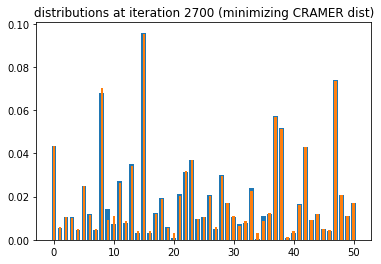

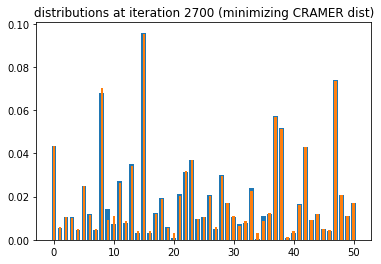

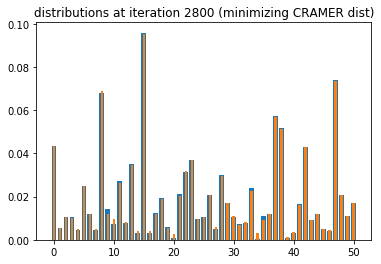

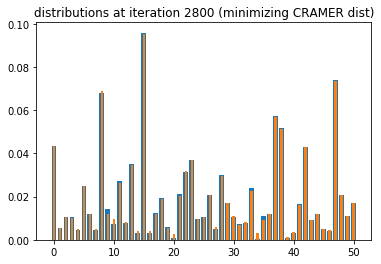

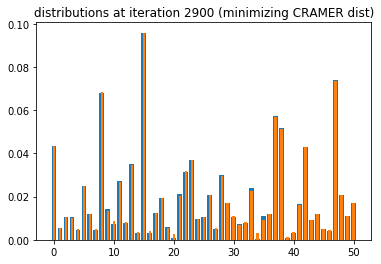

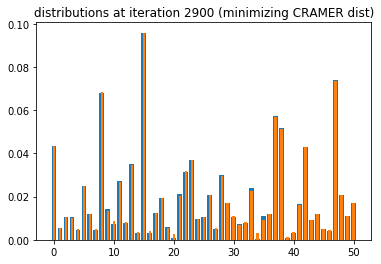

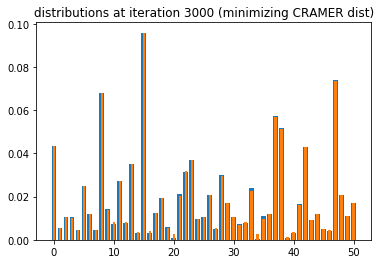

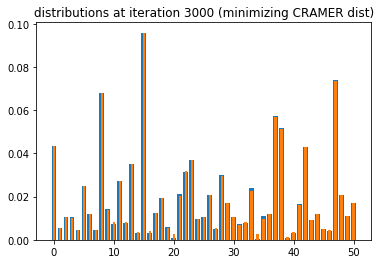

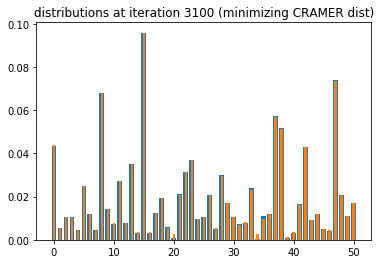

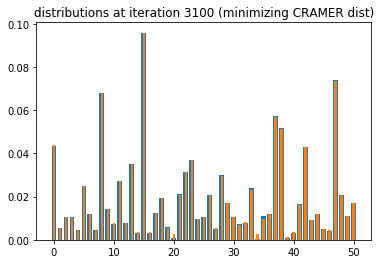

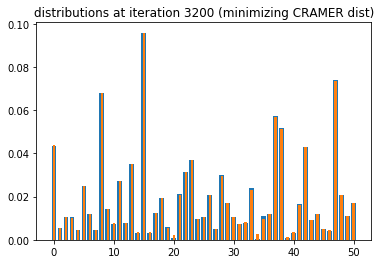

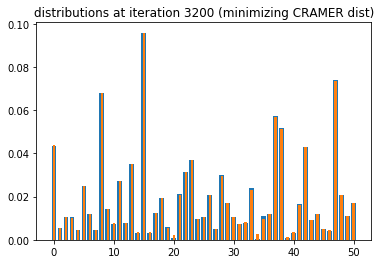

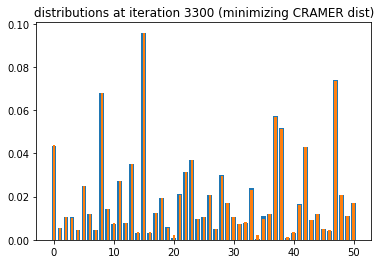

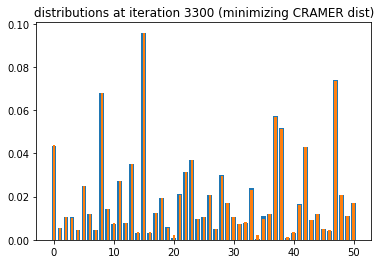

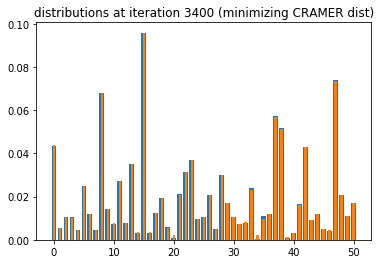

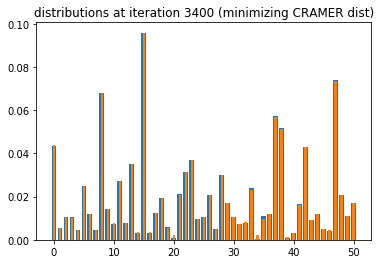

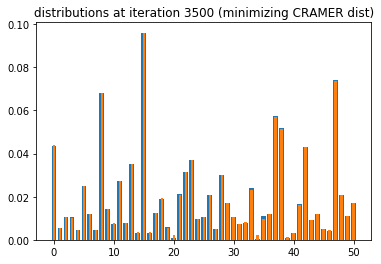

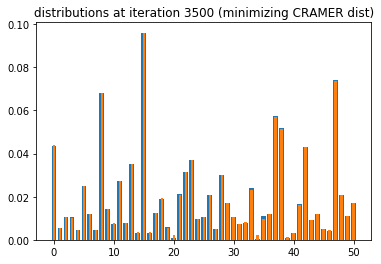

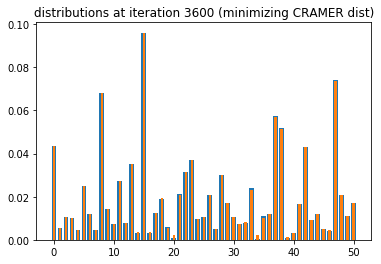

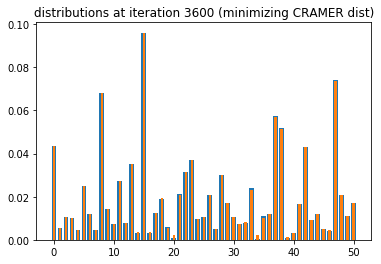

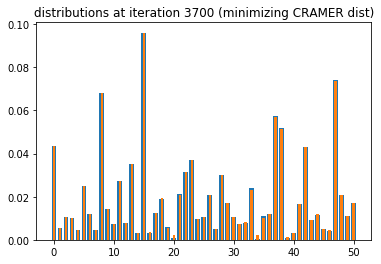

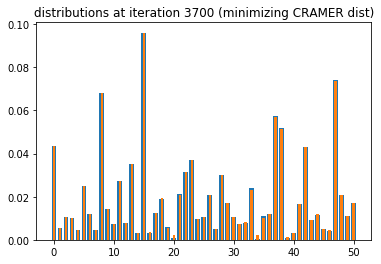

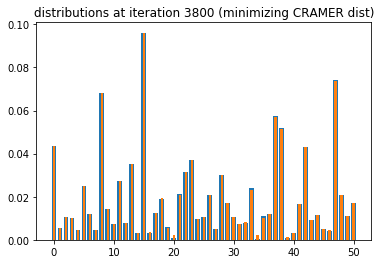

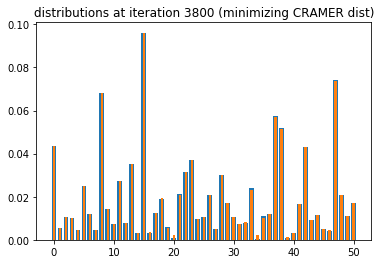

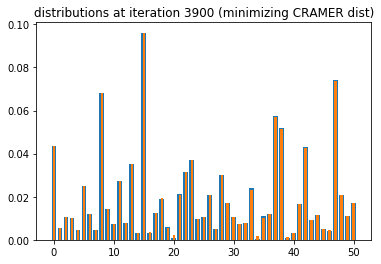

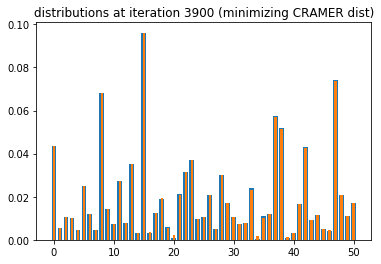

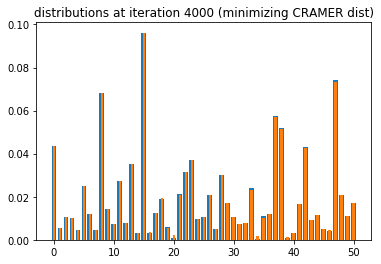

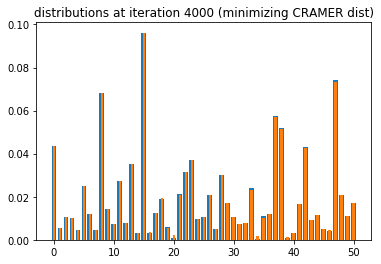

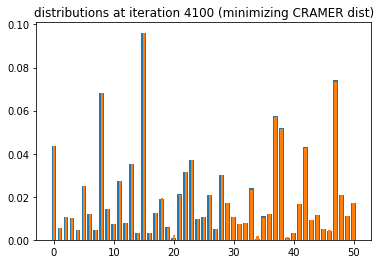

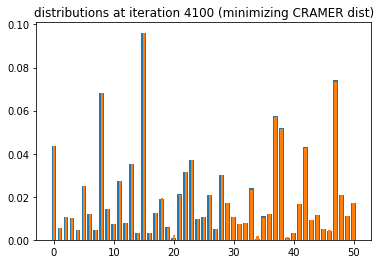

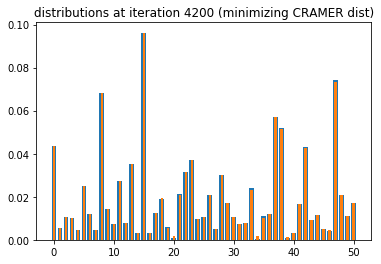

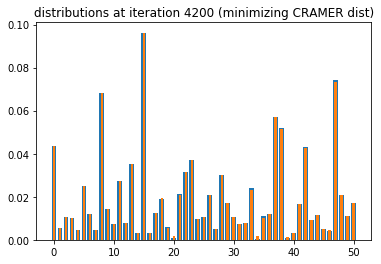

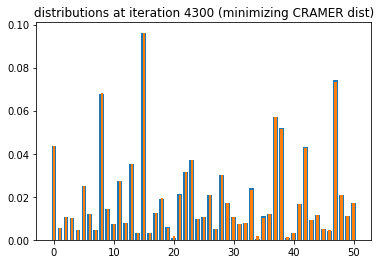

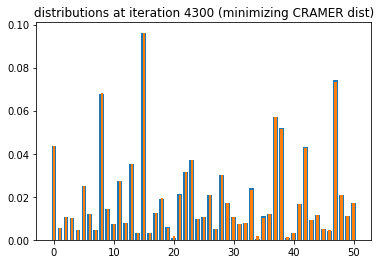

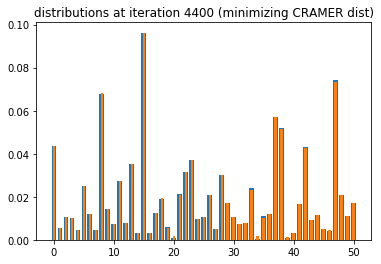

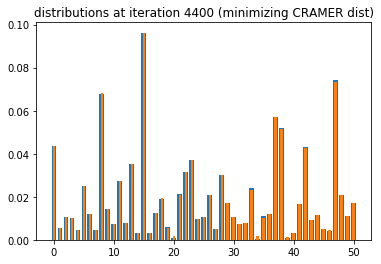

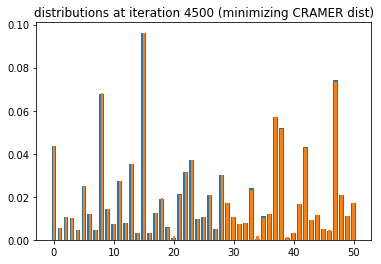

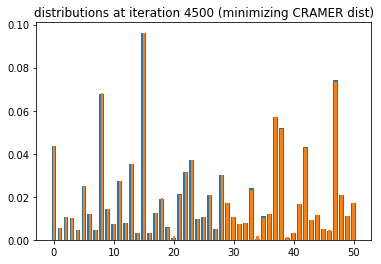

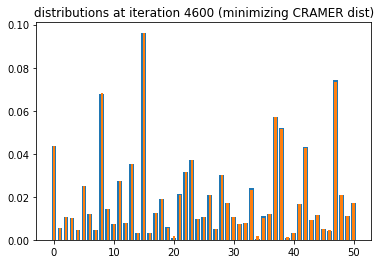

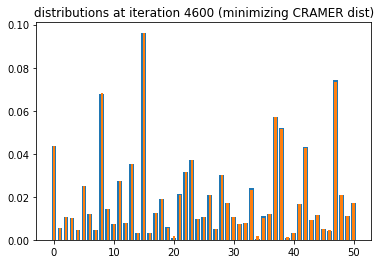

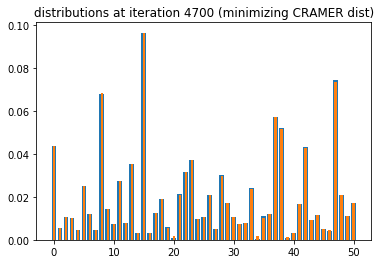

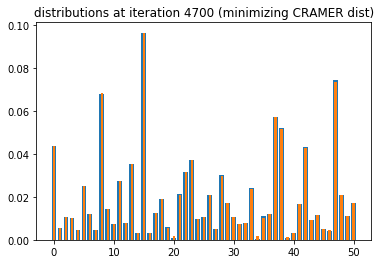

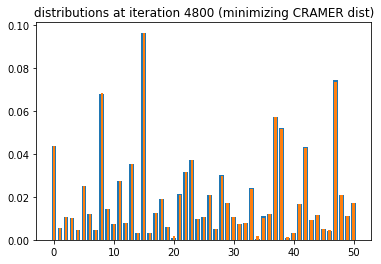

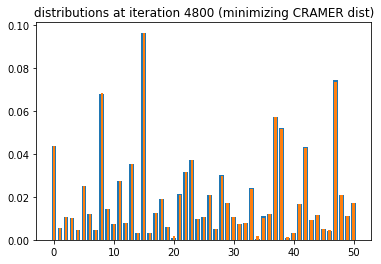

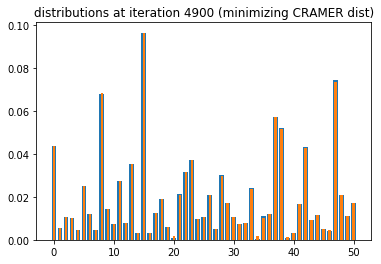

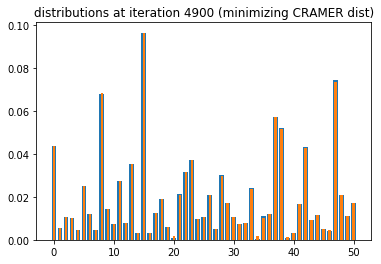

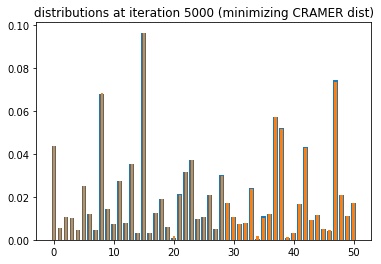

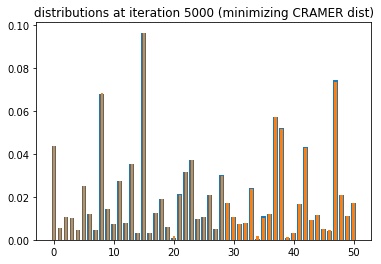

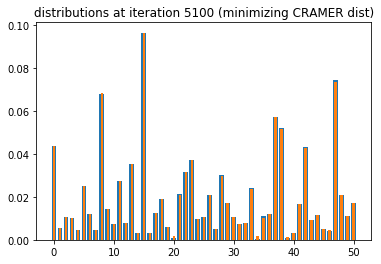

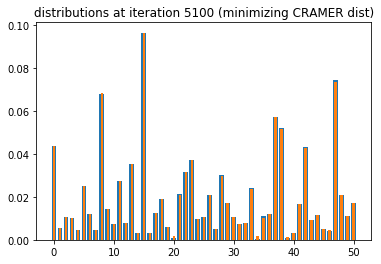

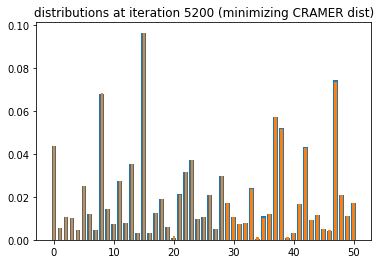

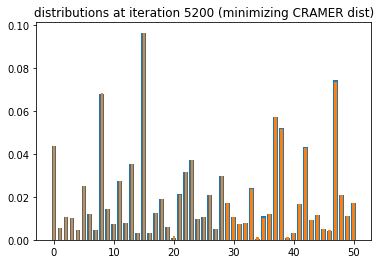

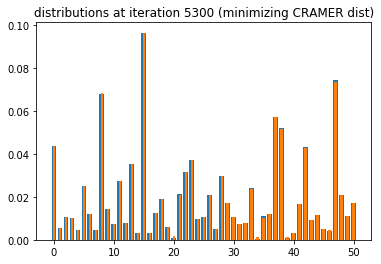

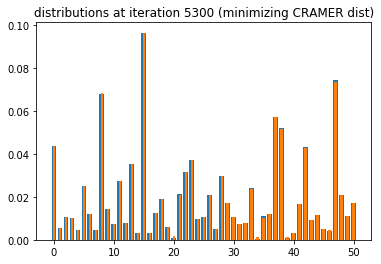

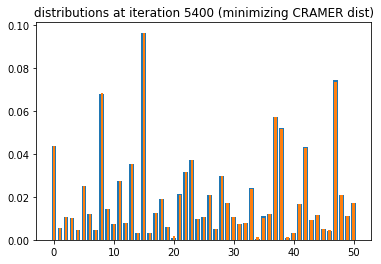

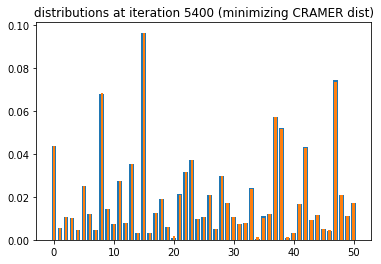

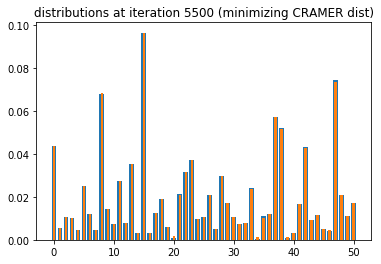

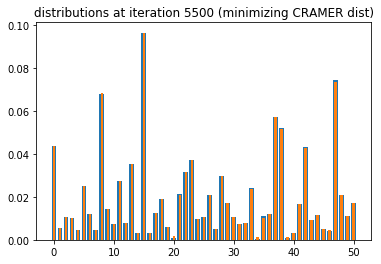

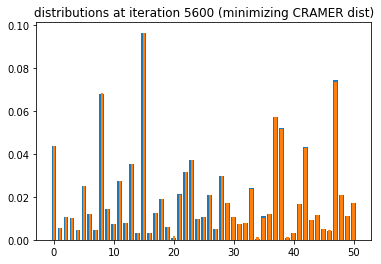

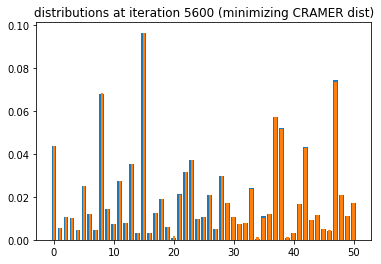

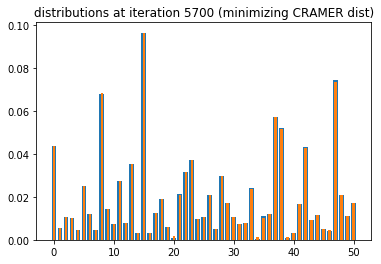

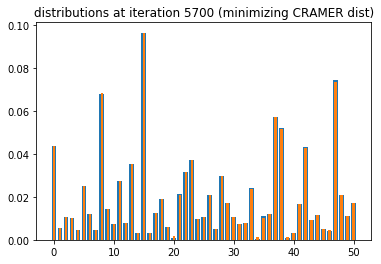

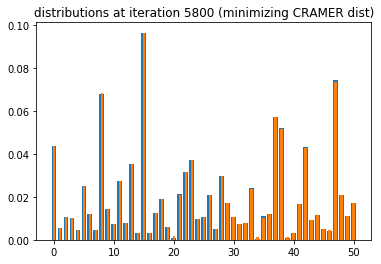

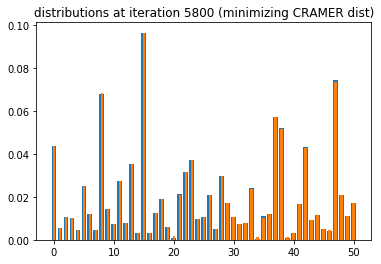

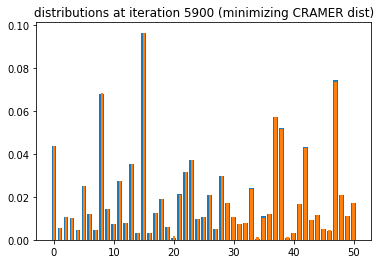

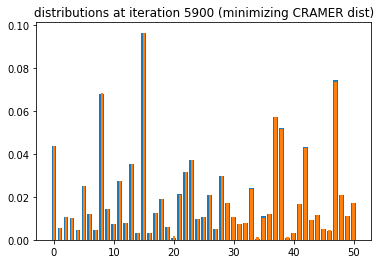

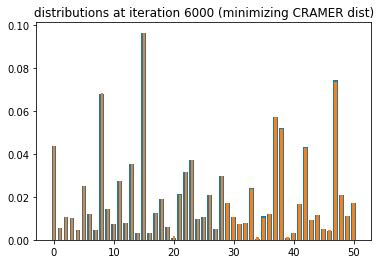

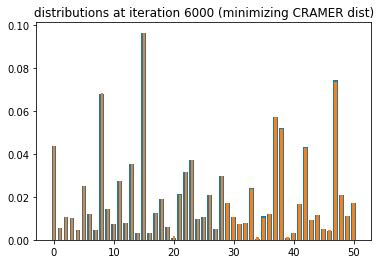

In [6]:
pmf_target = Variable(torch.from_numpy(create_random_dist()).float())
theta = Variable(torch.FloatTensor(pmf_target.size()).normal_(), requires_grad=True)
optimizer = optim.SGD([theta], lr = 0.1, momentum=0.9)

for i in range(6001):
    pmf_theta = F.softmax(theta, dim=0)
    loss = Cramer_Loss(pmf_theta, pmf_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i < 1000 and i % 10 == 0 or i % 100 == 0: 
        plot_dists(pmf_target.data.numpy(), pmf_theta.data.numpy(), i, save=True)
        

In [8]:
# let's save the plots as a gif 
import imageio
import os 

MAX = 6000

filenames = os.listdir('emd/')
filenames = [x for x in filenames if 'png' in x]
filenames = sorted(filenames, key = lambda x : int(x.split('.')[0]))
filenames = [x for x in filenames if int(x.split('.')[0]) < MAX ]

with imageio.get_writer('emd/fitting_cramer.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(os.path.join('emd', filename))
        writer.append_data(image)